## **ENIGH** - EDA Filtrado y Comparación de Modelos
* 18 de Marzo del 2025
#### ESCOM - IPN: *Modelado Predictivo*
#### Prof. Claudia Blanquel

#### *Lic. Ciencia de Datos* - 6AM1

> Armas Ramirez Daniel

> Gutierrez Ramirez Alana Sofia

> Hernández Peña Irving Jafet

> Reyes Maldonado Oscar Romario

> Sanchez Garcia Miguel Alexander

#### **0° Introducción**

Datos obtenidos de:

> https://www.inegi.org.mx/programas/enigh/nc/2016/#datos_abiertos

**a.** Como primer paso, necesitamos **importar** todas las **librerias** que usaremos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import PowerTransformer

# For PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances

# For the random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Realizar predicciones
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Para la regresión logística
from sklearn.linear_model import LogisticRegression

# Para el árbol de decisión
from sklearn.tree import DecisionTreeClassifier

# Para el KNN
from sklearn.neighbors import KNeighborsClassifier


**b.** Extraer la tabla necesaria de la base de datos

In [3]:
concentradohogar_df = pd.read_csv('datasets-ENIGH/conjunto_de_datos_concentradohogar_enigh_2016_ns/conjunto_de_datos/conjunto_de_datos_concentradohogar_enigh_2016_ns.csv')

#### **1° Data Cleaning**

In [4]:
concentradohogar_df.head()

folioviv  foliohog  ubica_geo   ageb  tam_loc  est_socio  est_dis  upm  \
0  100003801         1   10010000  000-0        1          4        3   10   
1  100003802         1   10010000  000-0        1          4        3   10   
2  100003803         1   10010000  000-0        1          4        3   10   
3  100003804         1   10010000  000-0        1          4        3   10   
4  100003805         1   10010000  000-0        1          4        3   10   

   factor  clase_hog  ...  mater_serv  material  servicio  deposito  \
0     248          2  ...       98.36     98.36      0.00       0.0   
1     248          2  ...        0.00      0.00      0.00       0.0   
2     248          2  ...      172.13      0.00    172.13       0.0   
3     248          3  ...        0.00      0.00      0.00       0.0   
4     248          2  ...        0.00      0.00      0.00       0.0   

   prest_terc  pago_tarje  deudas  balance  otras_erog     smg  
0         0.0    17409.83     0.0      0.0         0.0  6573.6  
1         0.0     5360.65     0.0      0.0         0.0  6573.6  
2         0.0    23606.55     0.0      0.0         0.0  6573.6  
3         0.0     8852.45     0.0      0.0         0.0  6573.6  
4         0.0        0.00     0.0      0.0         0.0  6573.6  

[5 rows x 127 columns]

**a.** Declarar las características necesarias

In [5]:
# Lista que contiene las columnas que se consideran categorías
categorias = ['folioviv', 'sexo_jefe', 'edad_jefe', 'educa_jefe', 'tot_integ', 'hombres', 'mujeres', 'p12_64', 
              'p65mas', 'ocupados', 'percep_ing', 'perc_ocupa']

# Lista que contiene las columnas de ingresos
ingresos = ['ing_cor', 'percep_tot']

# Lista que contiene las columnas de gastos
gastos = ['gasto_mon', 'erogac_tot']

# Eliminamos las columnas que no son de interés (no están en las listas anteriores)
for columna in concentradohogar_df.columns:
    if columna not in categorias and columna not in ingresos and columna not in gastos:
        concentradohogar_df.drop(columna, axis=1, inplace=True)

In [6]:
# Valores nulos por columna
print(concentradohogar_df.isnull().sum())

folioviv      0
sexo_jefe     0
edad_jefe     0
educa_jefe    0
tot_integ     0
hombres       0
mujeres       0
p12_64        0
p65mas        0
ocupados      0
percep_ing    0
perc_ocupa    0
ing_cor       0
gasto_mon     0
percep_tot    0
erogac_tot    0
dtype: int64


In [7]:
data = concentradohogar_df.copy()

# Juntar gastos
data['total_gasto'] = data['gasto_mon'] + data['erogac_tot']

data.drop(['gasto_mon', 'erogac_tot'], axis=1, inplace=True)

# Junta ingresos
data['total_ingreso'] = data['ing_cor'] + data['percep_tot']

data.drop(['ing_cor', 'percep_tot'], axis=1, inplace=True)

print(data.shape)

data.head()


(70311, 14)


folioviv  sexo_jefe  edad_jefe  educa_jefe  tot_integ  hombres  mujeres  \
0  100003801          1         33          10          2        1        1   
1  100003802          1         29          10          2        1        1   
2  100003803          1         47          10          6        2        4   
3  100003804          2         29          11          3        0        3   
4  100003805          1         55          10          2        2        0   

   p12_64  p65mas  ocupados  percep_ing  perc_ocupa  total_gasto  \
0       2       0         2           2           2     64108.15   
1       2       0         2           2           2     87788.40   
2       3       0         1           1           1     78571.19   
3       3       0         2           3           2     51304.82   
4       2       0         1           1           1     47589.29   

   total_ingreso  
0      100696.70  
1      147496.59  
2       94622.95  
3       58278.65  
4       57295.07

In [8]:
# Guardar el nuevo dataset como un archivo CSV
data.to_csv('data_enigh/ENIGH_2016_cleaned.csv', index=False)

In [9]:
def his_plot(data, n, m):
    fig, sub_plots = plt.subplots(n, m, figsize=(20, 20))
    i = 0
    j = 0
    for column in data.columns:
        sns.histplot(data[column], kde=True, ax=sub_plots[i, j], bins=30)
        sub_plots[i, j].set_title('Distribution of ' + column)
        j += 1
        if j == m:
            i += 1
            j = 0
    plt.show()


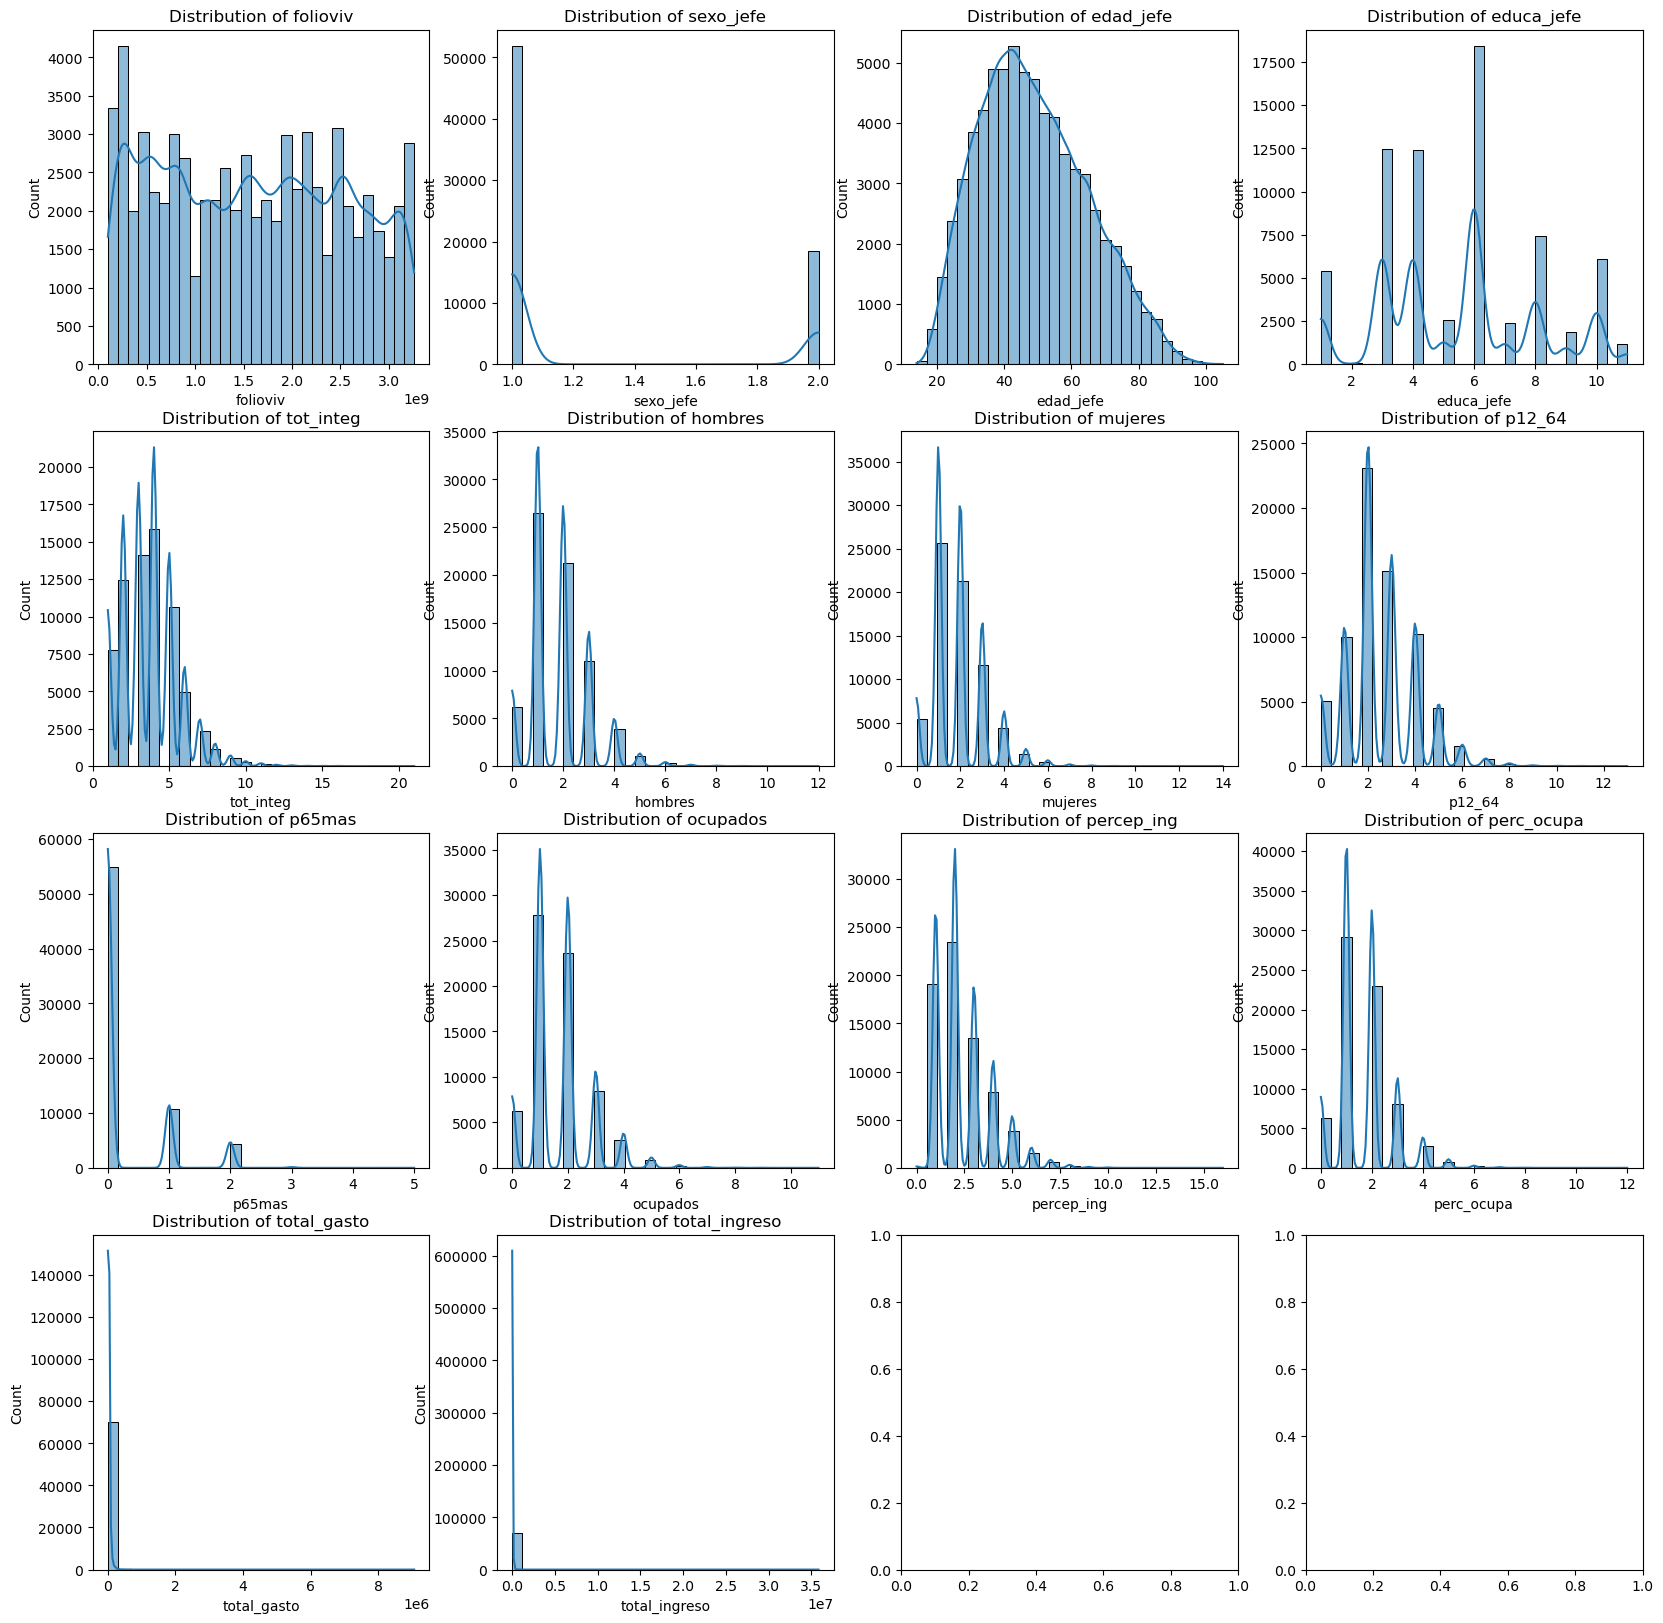

In [10]:
his_plot(data, 4, 4)

In [11]:
def q_q_plot(data, n, m):
    fig, sub_plots = plt.subplots(n, m, figsize=(20, 20))
    i = 0
    j = 0
    for column in data.columns:
        stats.probplot(data[column], dist="norm", plot=sub_plots[i, j])
        sub_plots[i, j].set_title('Q-Q Plot of ' + column)
        j += 1
        if j == m:
            i += 1
            j = 0
    plt.show()

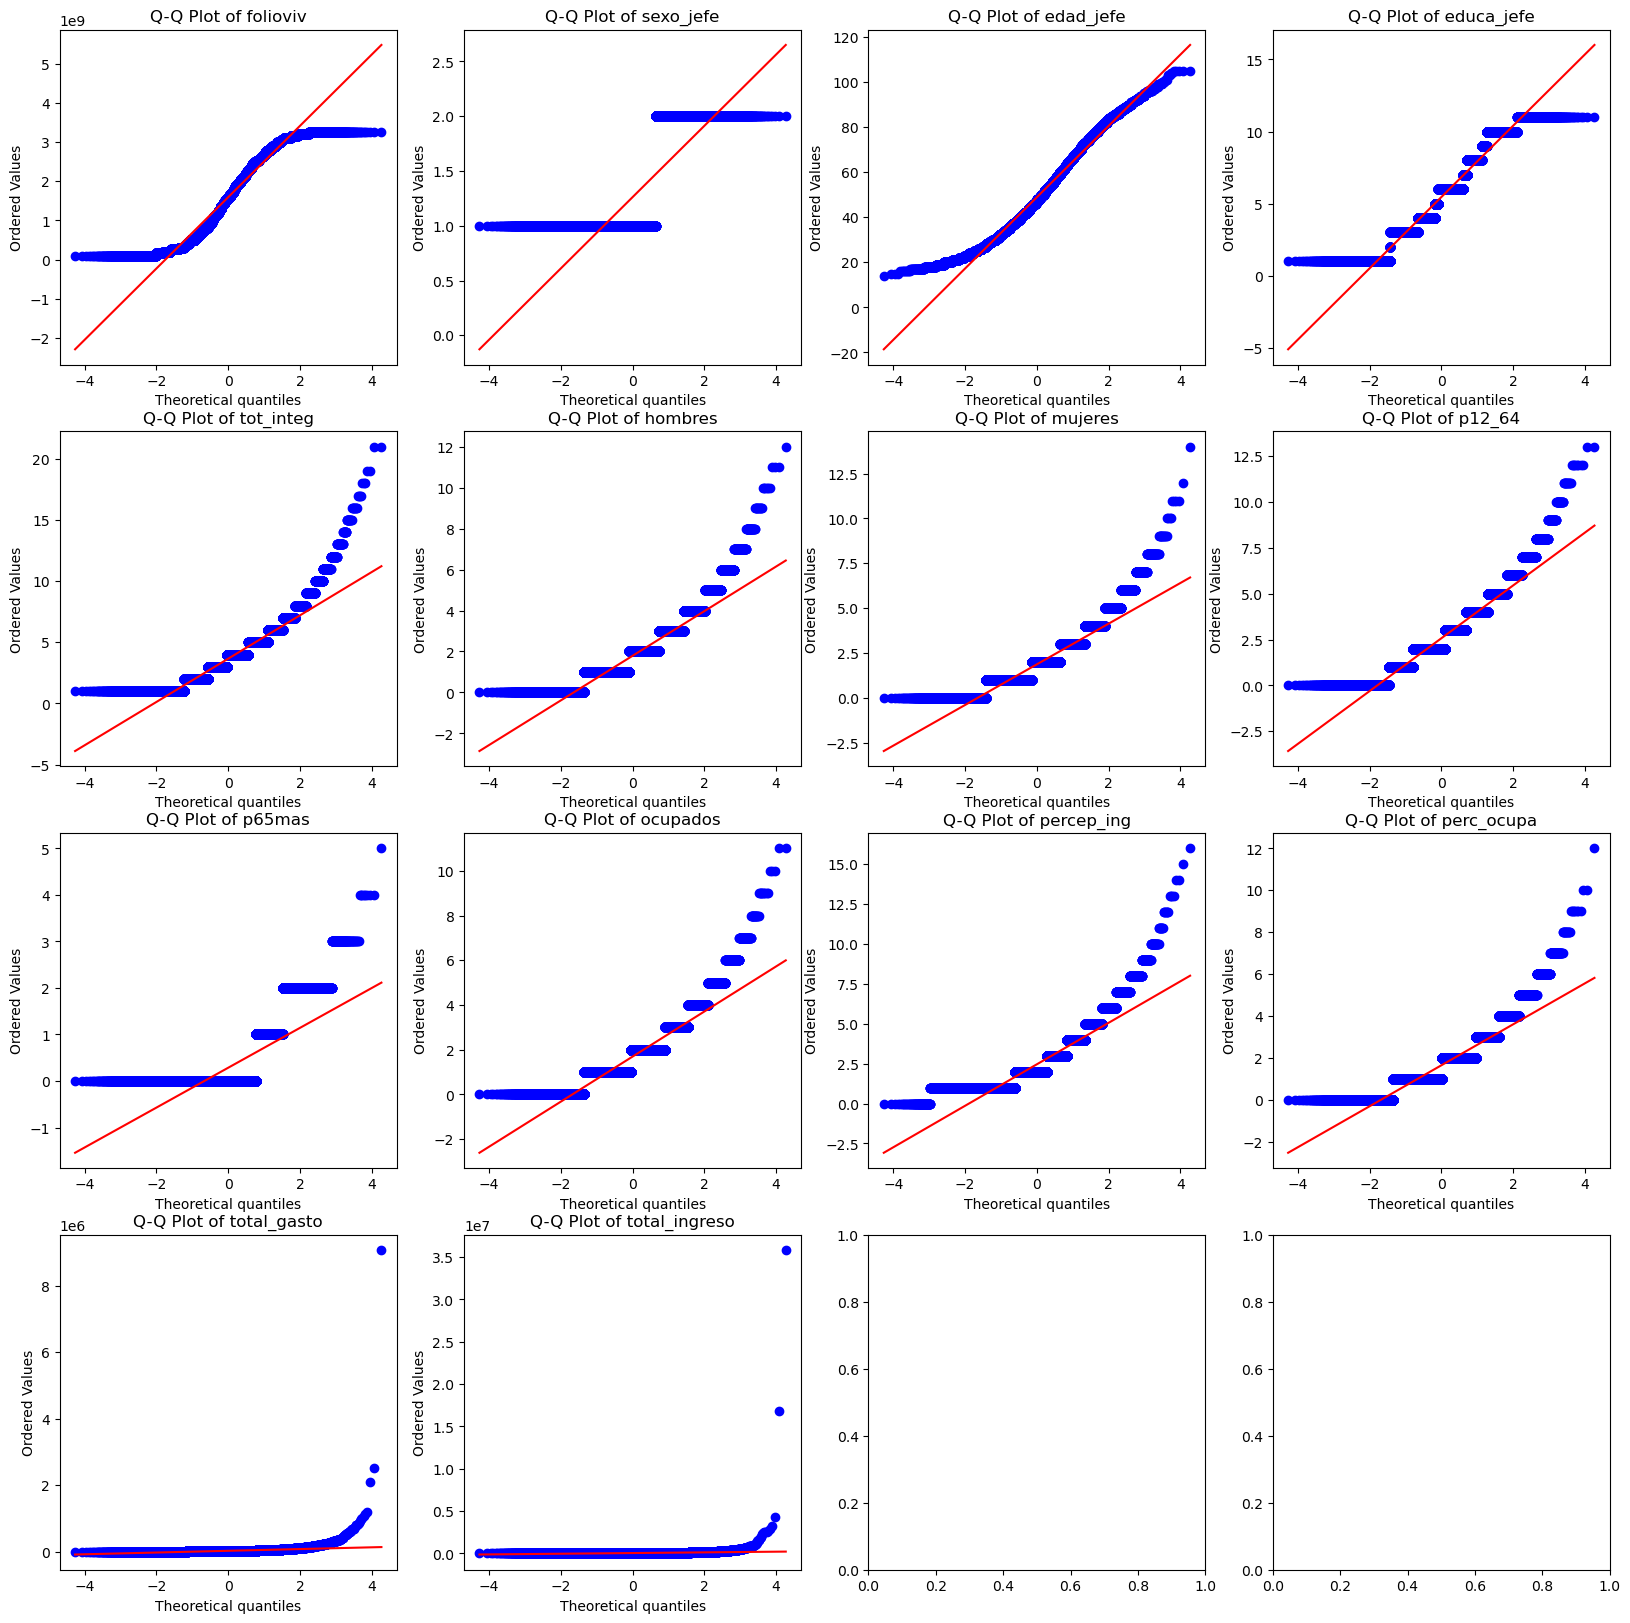

In [12]:
q_q_plot(data, 4, 4)

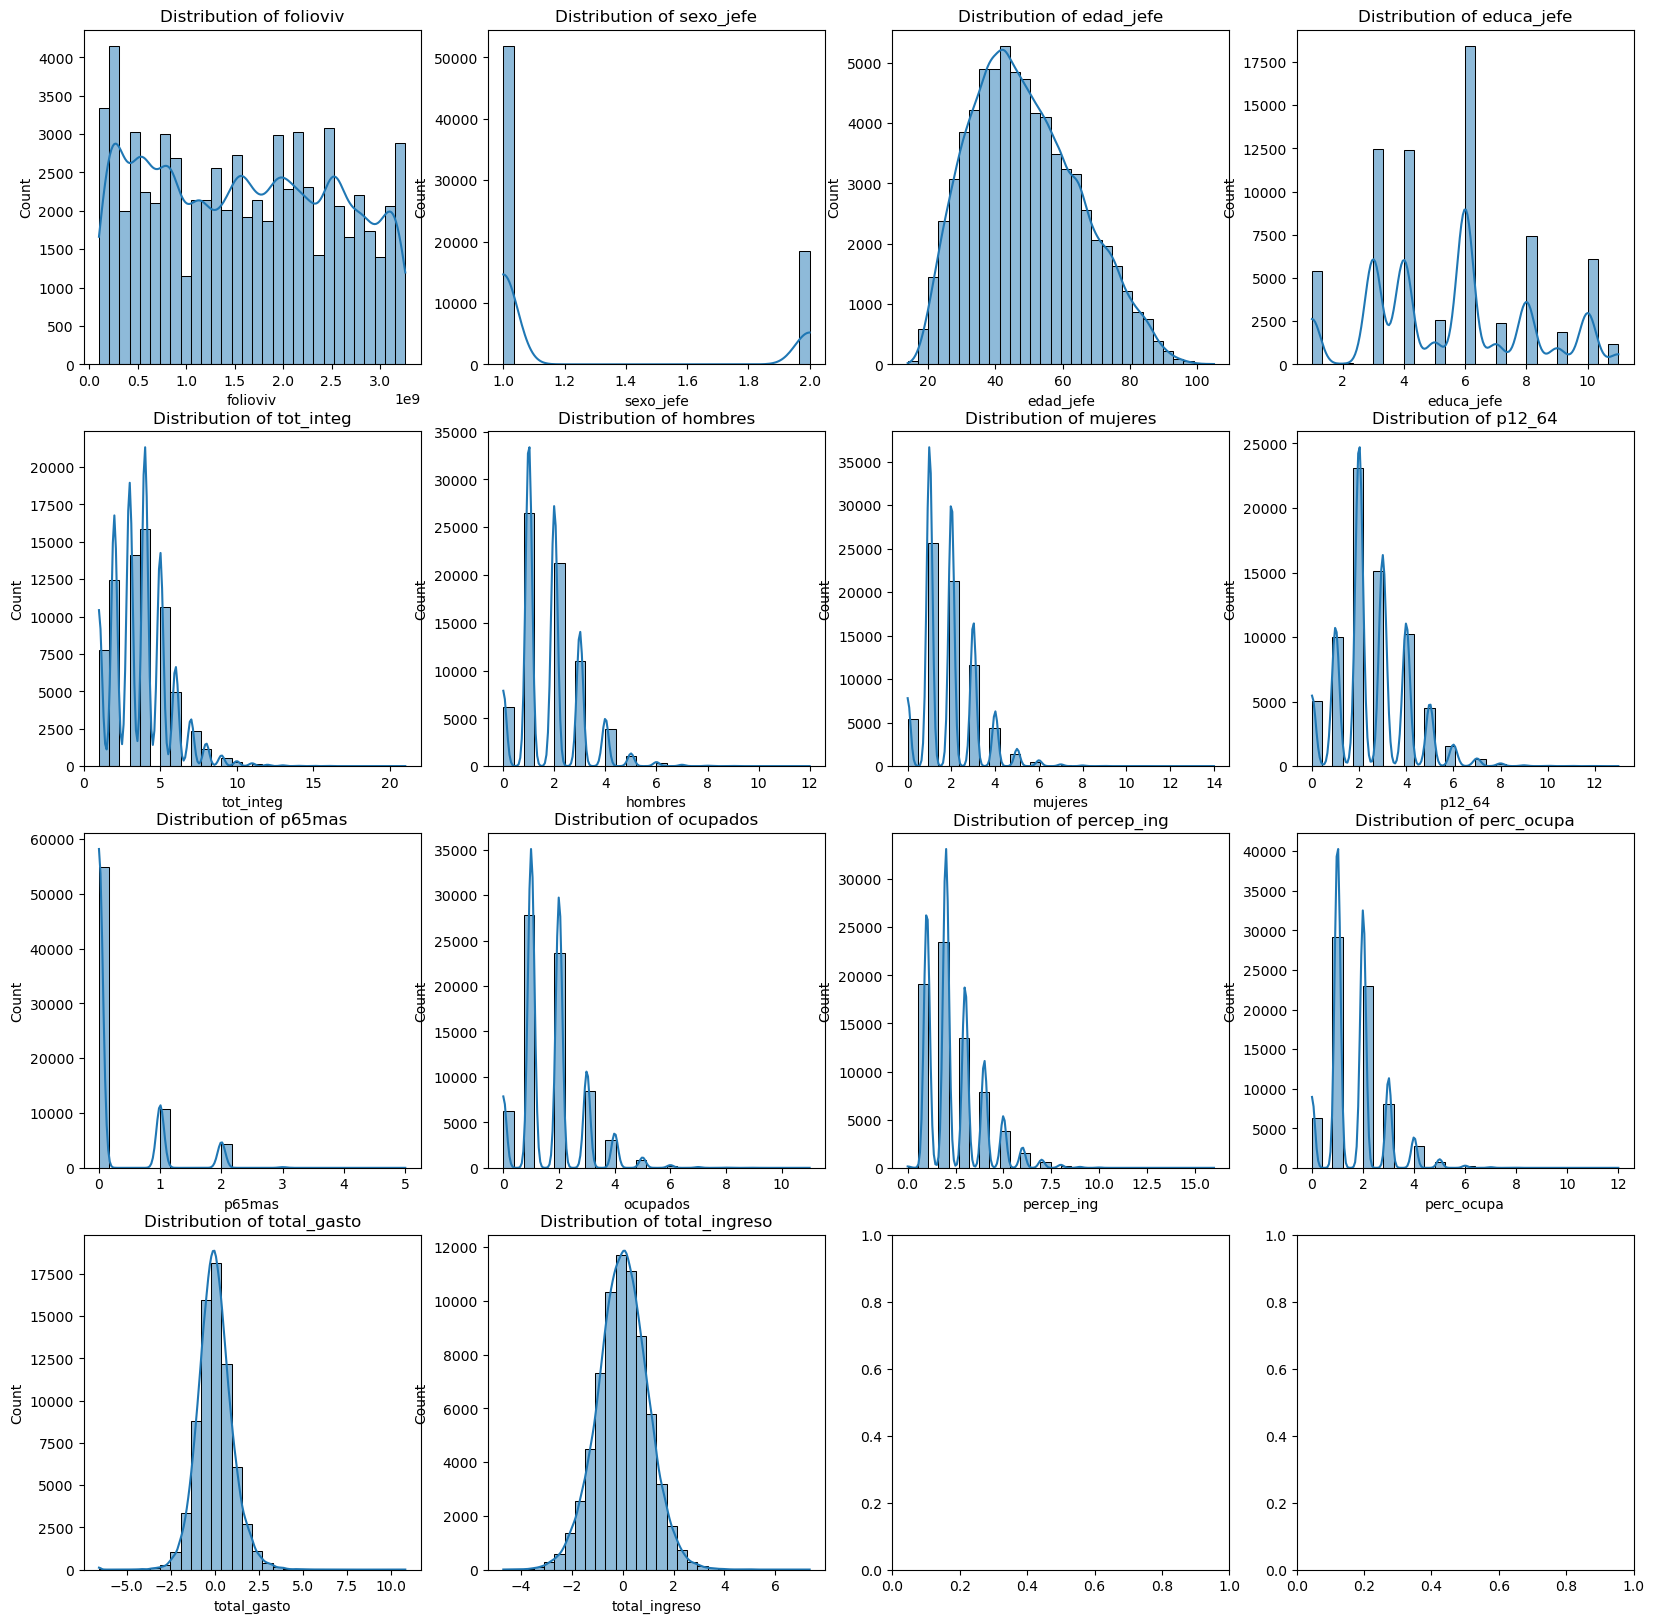

In [13]:
pt = PowerTransformer()

data['total_gasto'] = pt.fit_transform(data['total_gasto'].values.reshape(-1, 1))
data['total_ingreso'] = pt.fit_transform(data['total_ingreso'].values.reshape(-1, 1))

his_plot(data, 4, 4)

#### **2° EDA (Exploratory Data Analysis)**

##### *Datos Generales*

**a.** Revisar las **dimensiones** del dataset

In [14]:
print('Rows: ' + str(data.shape[0]))
print('Columns: ' + str(data.shape[1]))

Rows: 70311
Columns: 14


**b.** Mostrar las primeras **10 filas**

In [15]:
data.head(10)

folioviv  sexo_jefe  edad_jefe  educa_jefe  tot_integ  hombres  mujeres  \
0  100003801          1         33          10          2        1        1   
1  100003802          1         29          10          2        1        1   
2  100003803          1         47          10          6        2        4   
3  100003804          2         29          11          3        0        3   
4  100003805          1         55          10          2        2        0   
5  100010401          1         66          10          5        2        3   
6  100010402          2         74          11          2        1        1   
7  100010404          1         83          10          2        1        1   
8  100010405          2         62           8          1        0        1   
9  100010406          1         53          10          4        2        2   

   p12_64  p65mas  ocupados  percep_ing  perc_ocupa  total_gasto  \
0       2       0         2           2           2     1.374212   
1       2       0         2           2           2     1.809387   
2       3       0         1           1           1     1.653795   
3       3       0         2           3           2     1.076402   
4       2       0         1           1           1     0.977841   
5       2       2         4           4           4     0.611867   
6       0       2         0           1           0    -0.291749   
7       0       2         0           1           0    -1.007890   
8       1       0         0           1           0     0.646756   
9       4       0         2           2           2     1.124618   

   total_ingreso  
0       1.467310  
1       1.924093  
2       1.391744  
3       0.792149  
4       0.770736  
5       2.006032  
6       0.111106  
7      -0.370627  
8       1.105096  
9       1.062015

**c.** Mostrar las ultimas **10 filas**

In [16]:
data.tail(10)

folioviv  sexo_jefe  edad_jefe  educa_jefe  tot_integ  hombres  \
70301  3260801319          1         63           8          2        1   
70302  3260801320          1         54           6          4        2   
70303  3260801321          1         37           8          5        2   
70304  3260801322          1         64           6          3        1   
70305  3260801323          1         60           8          1        1   
70306  3260801324          1         49           3          4        2   
70307  3260801902          2         74           1          1        0   
70308  3260801904          1         77           3          1        1   
70309  3260801905          1         67           9          3        1   
70310  3260801906          1         62           5          5        2   

       mujeres  p12_64  p65mas  ocupados  percep_ing  perc_ocupa  total_gasto  \
70301        1       2       0         0           2           0    -0.396379   
70302        2       4       0         3           3           3    -0.942894   
70303        3       2       0         2           3           2     0.970279   
70304        2       2       1         1           2           1    -2.675728   
70305        0       1       0         1           1           1     0.087599   
70306        2       3       0         2           3           2    -0.178077   
70307        1       0       1         0           1           0    -1.699648   
70308        0       0       1         1           1           1    -1.216030   
70309        2       1       1         0           1           0     0.366241   
70310        3       4       0         3           3           3    -0.545520   

       total_ingreso  
70301       0.220308  
70302      -1.303236  
70303       0.209724  
70304      -2.637988  
70305      -0.129564  
70306      -0.254763  
70307      -0.579042  
70308      -0.404688  
70309      -0.306555  
70310      -0.752750

**d.** Obtener la **info** del dataset

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70311 entries, 0 to 70310
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   folioviv       70311 non-null  int64  
 1   sexo_jefe      70311 non-null  int64  
 2   edad_jefe      70311 non-null  int64  
 3   educa_jefe     70311 non-null  int64  
 4   tot_integ      70311 non-null  int64  
 5   hombres        70311 non-null  int64  
 6   mujeres        70311 non-null  int64  
 7   p12_64         70311 non-null  int64  
 8   p65mas         70311 non-null  int64  
 9   ocupados       70311 non-null  int64  
 10  percep_ing     70311 non-null  int64  
 11  perc_ocupa     70311 non-null  int64  
 12  total_gasto    70311 non-null  float64
 13  total_ingreso  70311 non-null  float64
dtypes: float64(2), int64(12)
memory usage: 7.5 MB


##### *Analisis Numérico*

**e.** **Estadisticas básicas** del dataset

In [18]:
data.describe()

folioviv     sexo_jefe     edad_jefe    educa_jefe     tot_integ  \
count  7.031100e+04  70311.000000  70311.000000  70311.000000  70311.000000   
mean   1.594219e+09      1.261595     48.965965      5.448550      3.664548   
std    9.323485e+08      0.439506     15.988477      2.544413      1.841030   
min    1.000038e+08      1.000000     14.000000      1.000000      1.000000   
25%    7.621785e+08      1.000000     37.000000      3.000000      2.000000   
50%    1.562090e+09      1.000000     47.000000      6.000000      4.000000   
75%    2.402681e+09      2.000000     60.000000      7.000000      5.000000   
max    3.260802e+09      2.000000    105.000000     11.000000     21.000000   

            hombres       mujeres        p12_64        p65mas      ocupados  \
count  70311.000000  70311.000000  70311.000000  70311.000000  70311.000000   
mean       1.791171      1.873377      2.566540      0.285702      1.694500   
std        1.157776      1.203629      1.487598      0.585255      1.078737   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      1.000000      2.000000      0.000000      1.000000   
50%        2.000000      2.000000      2.000000      0.000000      2.000000   
75%        2.000000      3.000000      3.000000      0.000000      2.000000   
max       12.000000     14.000000     13.000000      5.000000     11.000000   

         percep_ing    perc_ocupa   total_gasto  total_ingreso  
count  70311.000000  70311.000000  7.031100e+04   7.031100e+04  
mean       2.466115      1.649031 -1.358208e-15  -3.460196e-16  
std        1.403639      1.048979  1.000007e+00   1.000007e+00  
min        0.000000      0.000000 -6.581060e+00  -4.692670e+00  
25%        1.000000      1.000000 -6.180693e-01  -6.371138e-01  
50%        2.000000      1.000000 -3.557731e-02   6.985568e-03  
75%        3.000000      2.000000  5.731585e-01   6.486431e-01  
max       16.000000     12.000000  1.080243e+01   7.353444e+00

**f.** Let´s check the **number and percentage of the null values** for each dimension

In [19]:
data.isnull().sum()

folioviv         0
sexo_jefe        0
edad_jefe        0
educa_jefe       0
tot_integ        0
hombres          0
mujeres          0
p12_64           0
p65mas           0
ocupados         0
percep_ing       0
perc_ocupa       0
total_gasto      0
total_ingreso    0
dtype: int64

In [20]:
data.isnull().sum() / data.shape[0] * 100

folioviv         0.0
sexo_jefe        0.0
edad_jefe        0.0
educa_jefe       0.0
tot_integ        0.0
hombres          0.0
mujeres          0.0
p12_64           0.0
p65mas           0.0
ocupados         0.0
percep_ing       0.0
perc_ocupa       0.0
total_gasto      0.0
total_ingreso    0.0
dtype: float64

**g.** Let´s check the number of **duplicated values** of each dimension

In [21]:
duplicate_sums = data.apply(lambda col: col.duplicated().sum())
print(duplicate_sums)

folioviv          1142
sexo_jefe        70309
edad_jefe        70219
educa_jefe       70300
tot_integ        70291
hombres          70298
mujeres          70297
p12_64           70297
p65mas           70305
ocupados         70299
percep_ing       70294
perc_ocupa       70299
total_gasto        519
total_ingreso     1790
dtype: int64


##### *Analisis Visual*

In [22]:
# Set default plot color to black
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['black'])

**h.** **Distribuciones** de cada variable numérica

In [23]:
def his_plot(data, n, m):
    fig, sub_plots = plt.subplots(n, m, figsize=(20, 20))
    i = 0
    j = 0
    for column in data.columns:
        sns.histplot(data[column], kde=True, ax=sub_plots[i, j], bins=30)
        sub_plots[i, j].set_title('Distribution of ' + column)
        j += 1
        if j == m:
            i += 1
            j = 0
    plt.show()

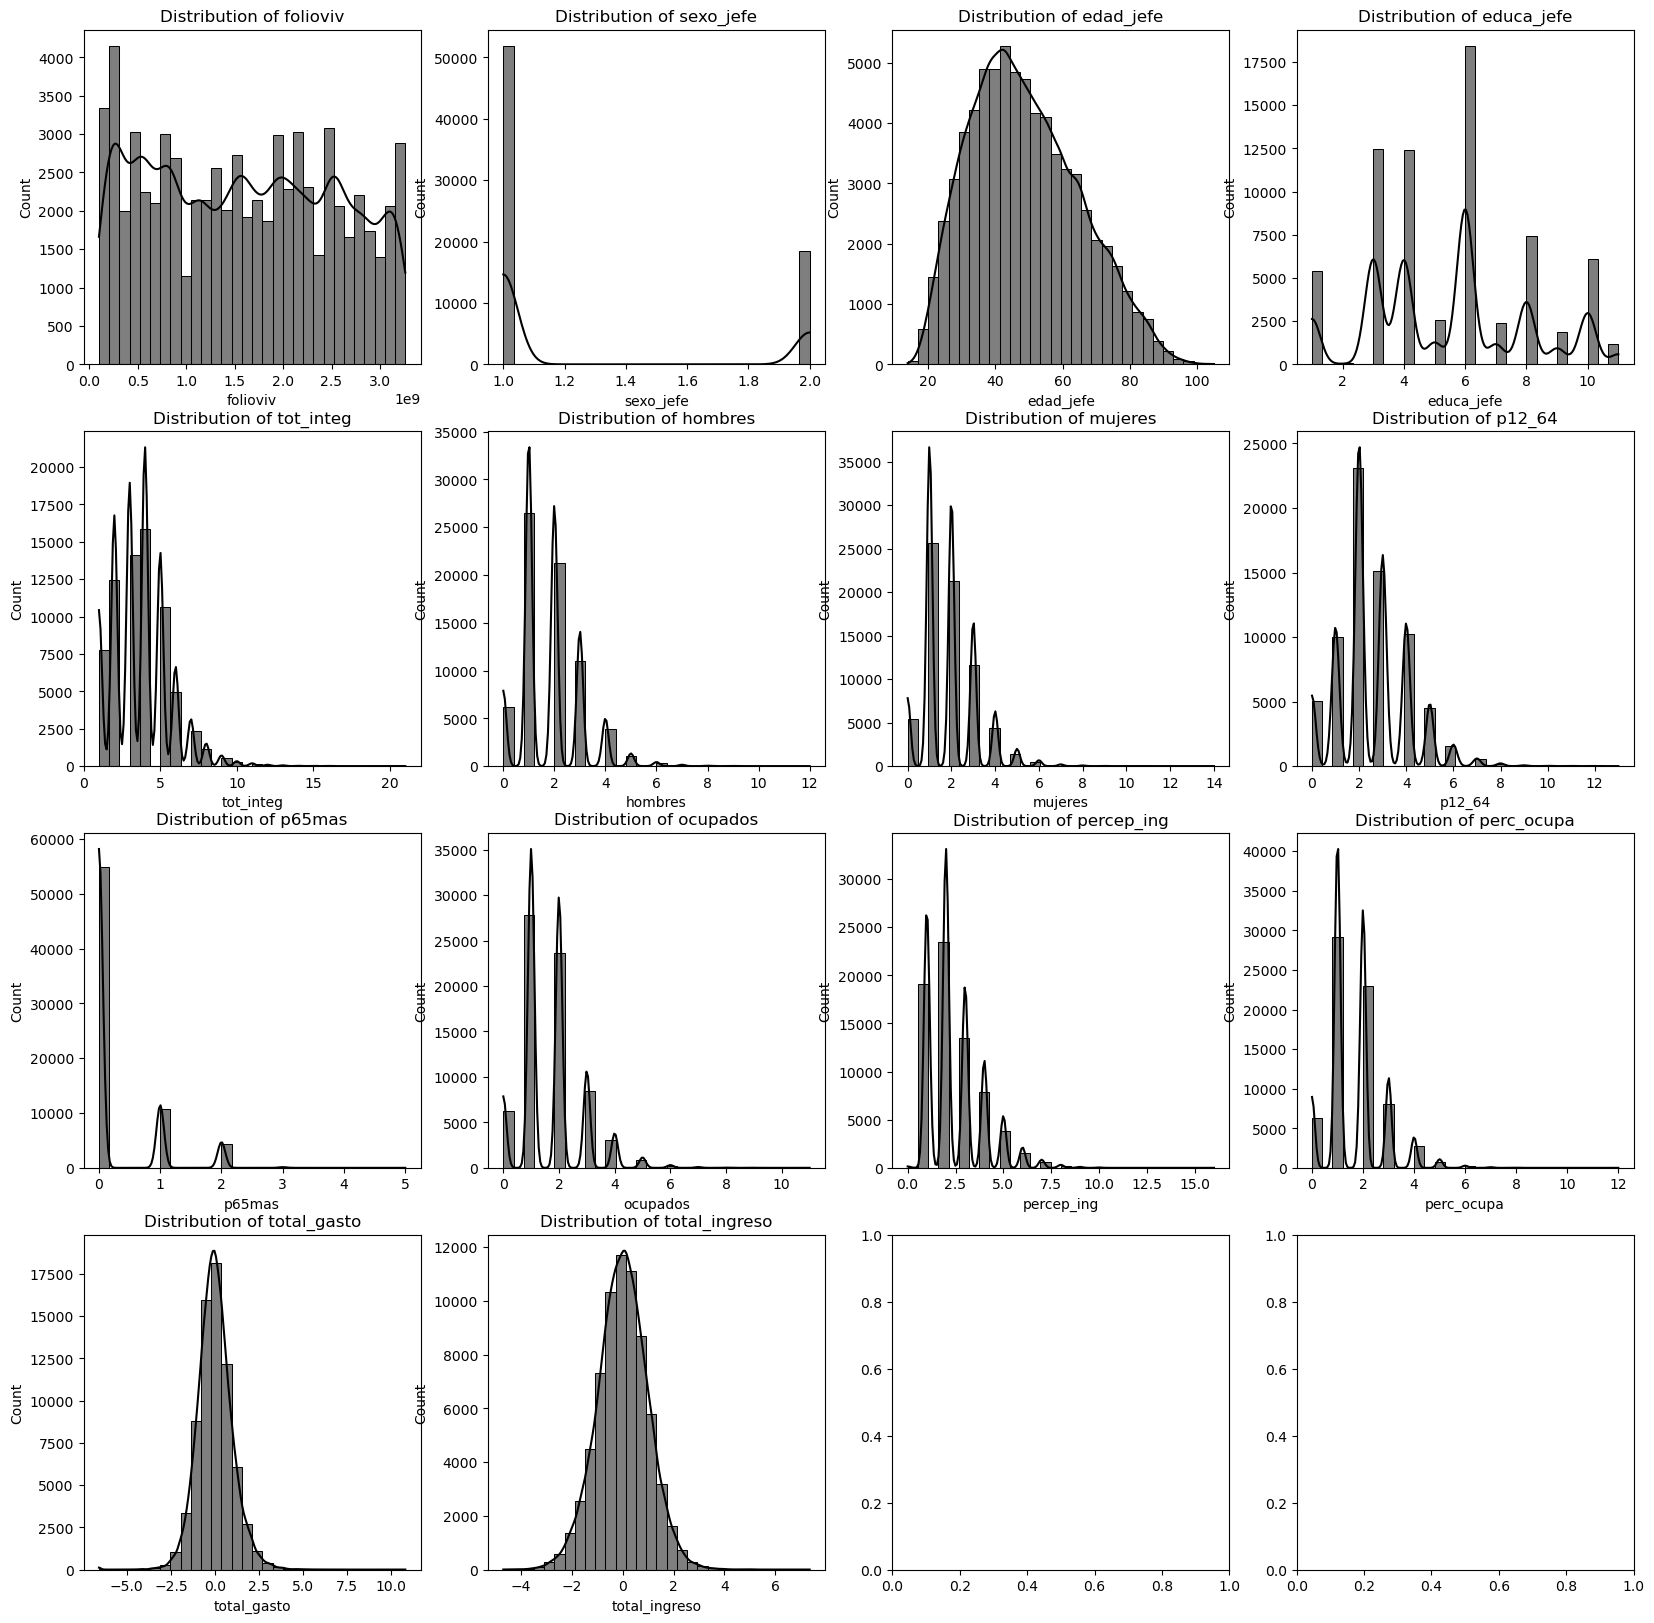

In [26]:
his_plot(data, 4, 4)

**i.** **Relación** entre las variables numéricas

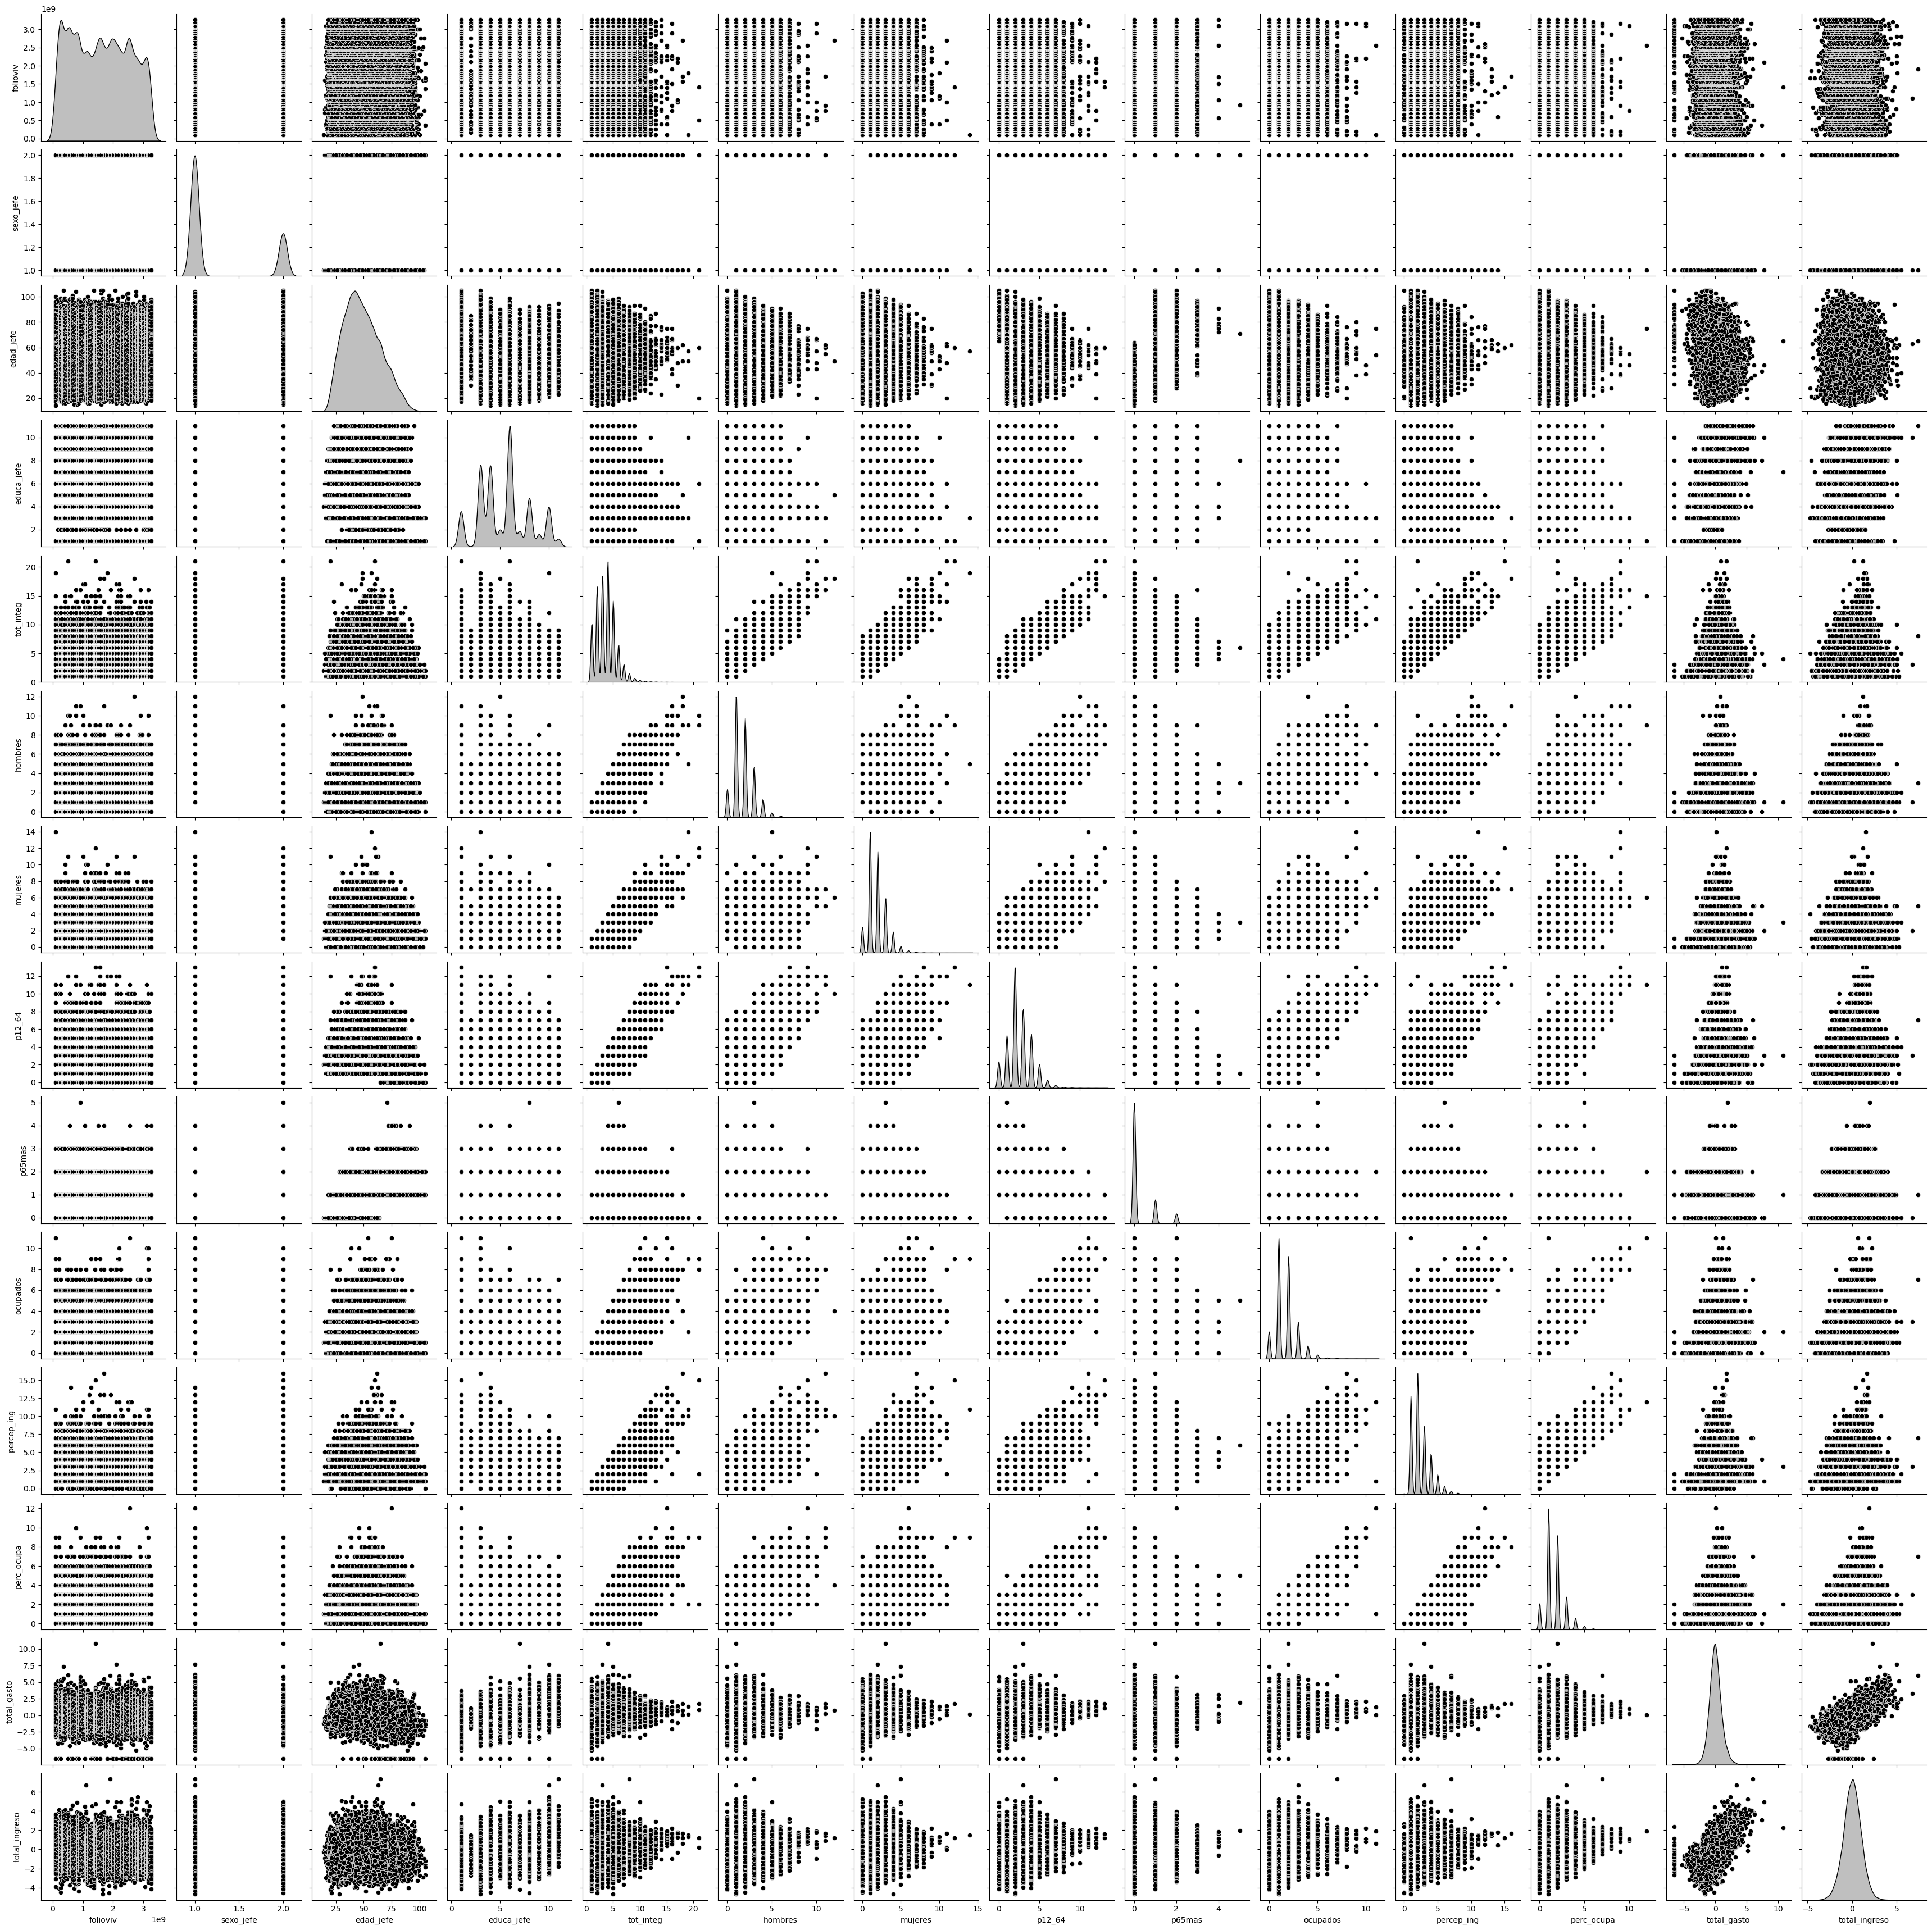

In [27]:
sns.pairplot(data, diag_kind='kde')
plt.show()

**j.** Q-Q Plot de las variables numéricas

In [28]:
def q_q_plot(data, n, m):
    fig, sub_plots = plt.subplots(n, m, figsize=(20, 20))
    i = 0
    j = 0
    for column in data.columns:
        stats.probplot(data[column], dist="norm", plot=sub_plots[i, j])
        sub_plots[i, j].set_title('Q-Q Plot of ' + column)
        j += 1
        if j == m:
            i += 1
            j = 0
    plt.show()

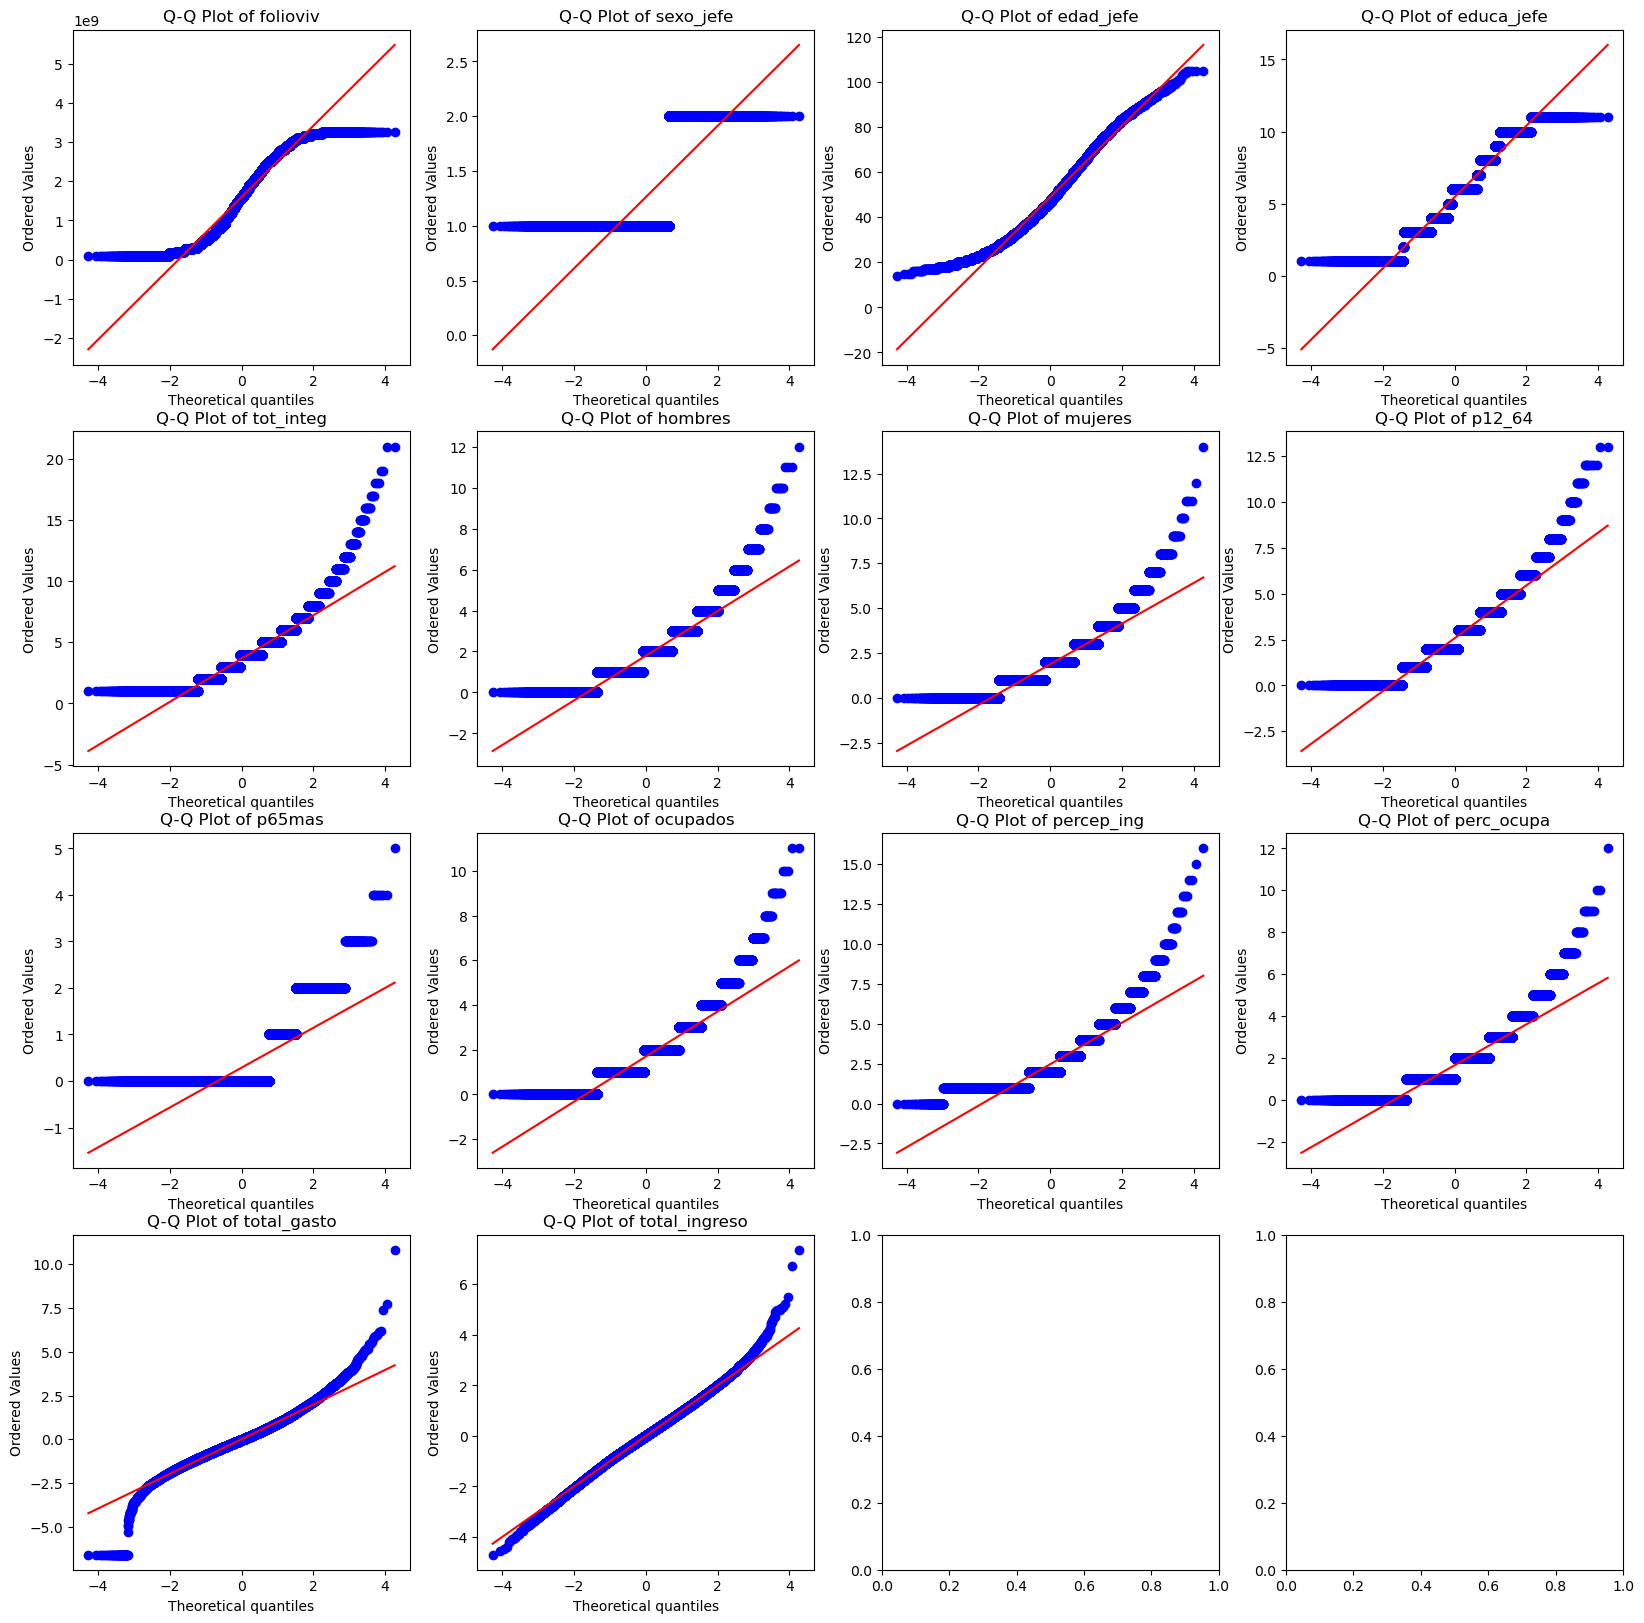

In [29]:
q_q_plot(data, 4, 4)

**k.** Boxplot de las variables numéricas

In [30]:
def box_plots(data, n, m):
    fig, sub_plots = plt.subplots(n, m, figsize=(20, 20))
    i = 0
    j = 0
    for column in data.columns:
        sns.boxplot(data[column], ax=sub_plots[i, j], color='gray')
        sub_plots[i, j].set_title('Box Plot of ' + column)
        j += 1
        if j == m:
            i += 1
            j = 0
    plt.show()

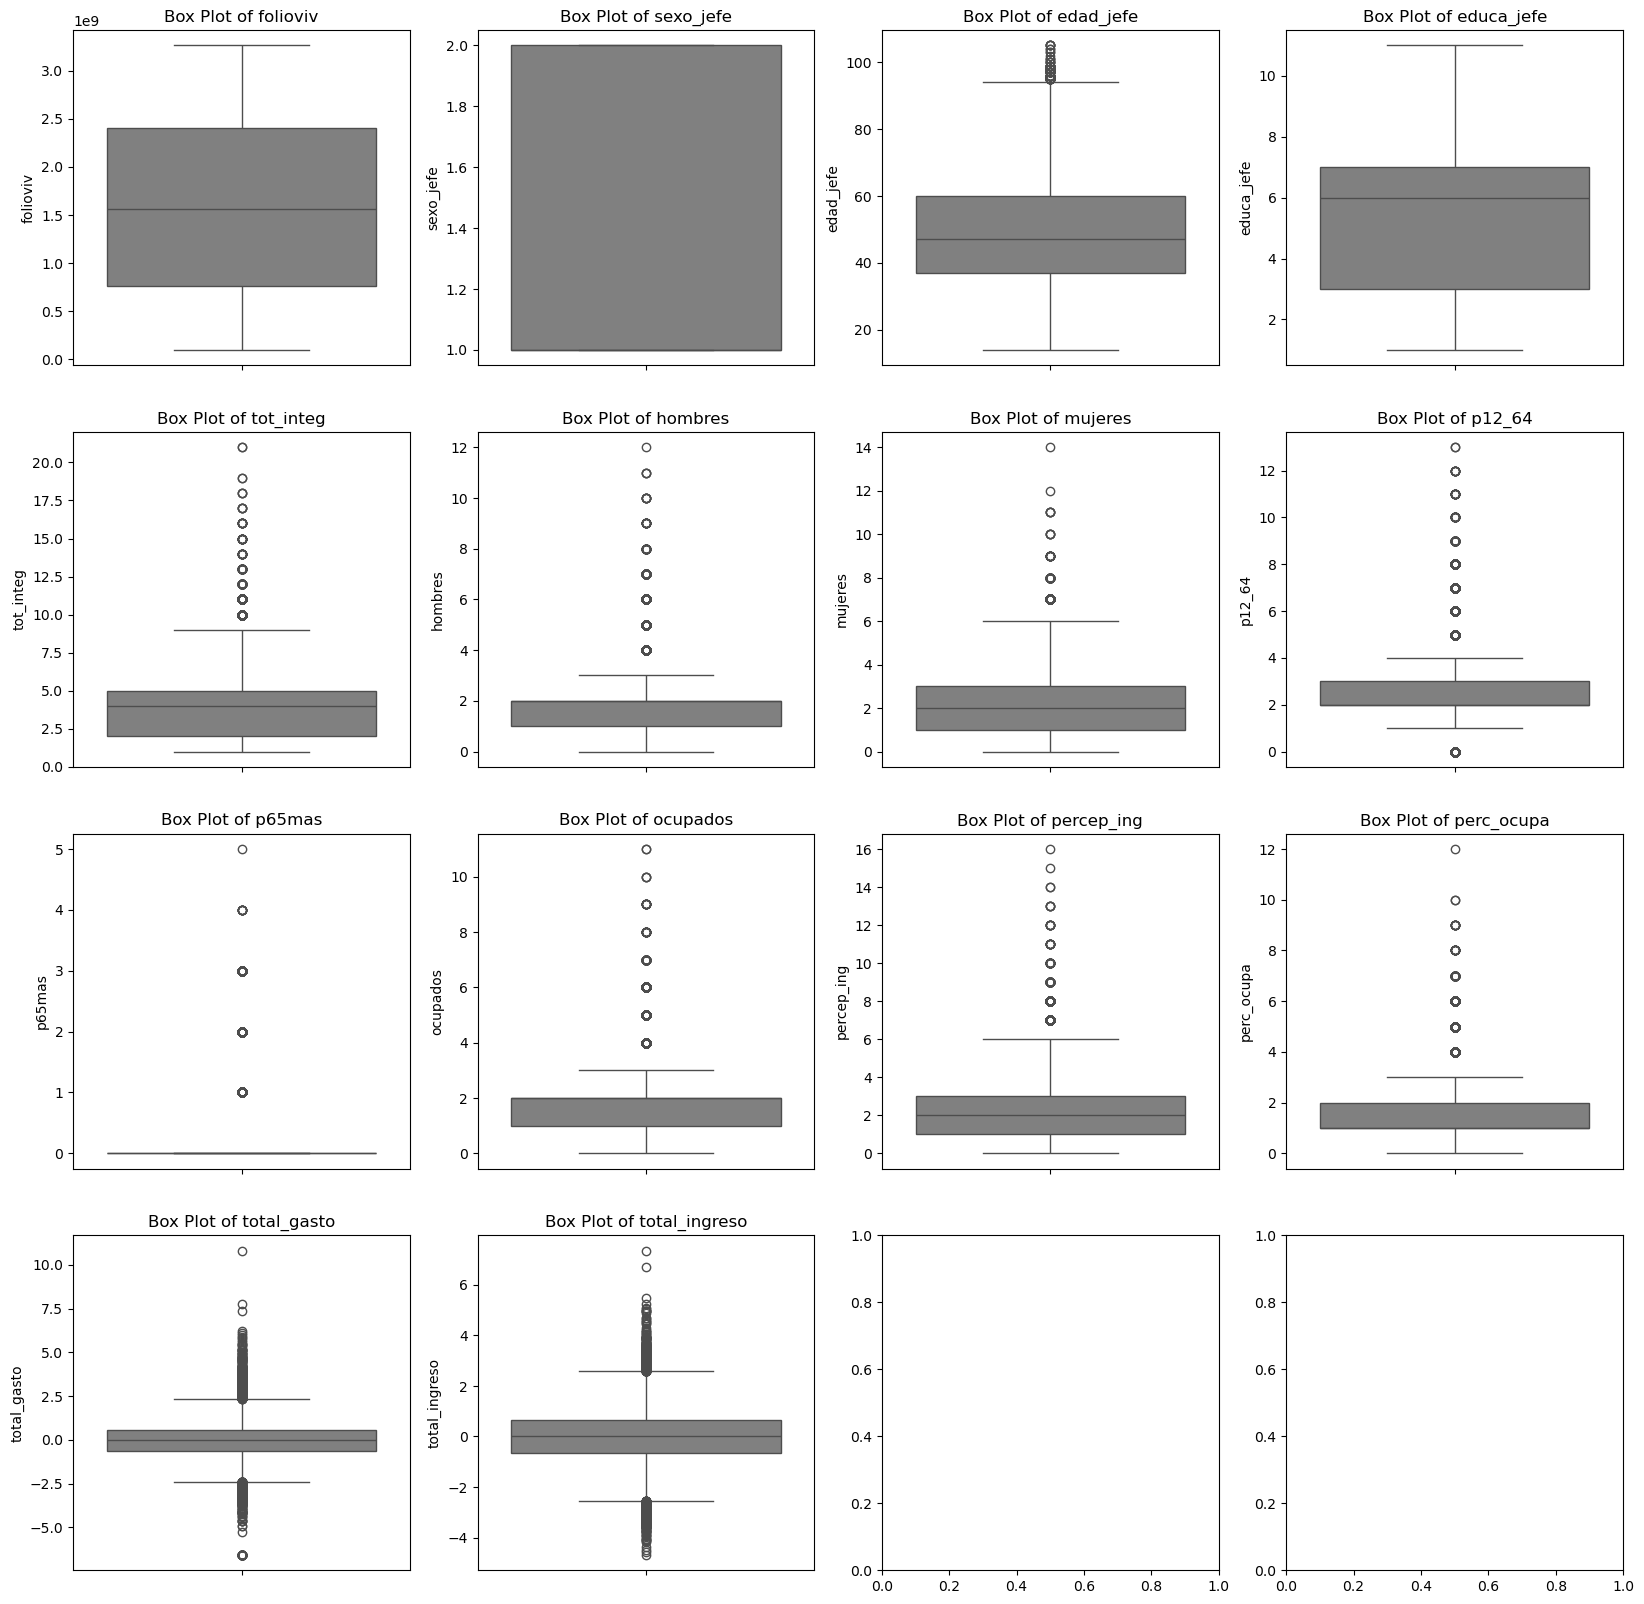

In [31]:
box_plots(data, 4, 4)

##### *Metodos estadísticos*

**l.** Z-Score

In [32]:
# Calcular el z-score de cada variable
z_scores = np.abs(data - data.mean()) / data.std()

outliers = data[(z_scores > 3).any(axis=1)]

outliers

folioviv  sexo_jefe  edad_jefe  educa_jefe  tot_integ  hombres  \
10      100027701          2         50          10          3        1   
14      100031901          2         41           4          9        4   
32      100068003          1         41           6          7        3   
56      100101404          2         85           3          1        0   
60      100103703          1         76           3          1        1   
...           ...        ...        ...         ...        ...      ...   
70265  3260774318          2         23           6          3        1   
70269  3260774422          1         60           3          3        2   
70292  3260801007          1         65          11          4        2   
70299  3260801215          1         55           6         10        6   
70300  3260801218          2         73           1          1        0   

       mujeres  p12_64  p65mas  ocupados  percep_ing  perc_ocupa  total_gasto  \
10           2       3       0         3           3           3     3.930861   
14           5       6       0         5           5           5     0.045483   
32           4       5       0         5           3           3    -0.203572   
56           1       0       1         0           1           0    -6.581060   
60           0       0       1         1           1           1    -1.765799   
...        ...     ...     ...       ...         ...         ...          ...   
70265        2       1       0         0           1           0    -1.485447   
70269        1       3       0         0           2           0    -2.391583   
70292        2       3       1         4           4           4     4.245051   
70299        4       5       1         4           5           4     0.974295   
70300        1       0       1         0           1           0    -0.769731   

       total_ingreso  
10          3.572102  
14         -0.414638  
32         -0.156635  
56          0.007552  
60         -3.059472  
...              ...  
70265      -3.562782  
70269      -3.085315  
70292       2.129269  
70299       0.641460  
70300      -4.139507  

[3534 rows x 14 columns]

**m.** Cuartiles e IQR

In [33]:
Q1 = data.quantile(0.25)
Q2 = data.quantile(0.50)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = data[((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

outliers_iqr

folioviv  sexo_jefe  edad_jefe  educa_jefe  tot_integ  hombres  \
5       100010401          1         66          10          5        2   
6       100010402          2         74          11          2        1   
7       100010404          1         83          10          2        1   
10      100027701          2         50          10          3        1   
11      100027702          1         69           4          5        1   
...           ...        ...        ...         ...        ...      ...   
70300  3260801218          2         73           1          1        0   
70304  3260801322          1         64           6          3        1   
70307  3260801902          2         74           1          1        0   
70308  3260801904          1         77           3          1        1   
70309  3260801905          1         67           9          3        1   

       mujeres  p12_64  p65mas  ocupados  percep_ing  perc_ocupa  total_gasto  \
5            3       2       2         4           4           4     0.611867   
6            1       0       2         0           1           0    -0.291749   
7            1       0       2         0           1           0    -1.007890   
10           2       3       0         3           3           3     3.930861   
11           4       1       2         3           3           3     1.014478   
...        ...     ...     ...       ...         ...         ...          ...   
70300        1       0       1         0           1           0    -0.769731   
70304        2       2       1         1           2           1    -2.675728   
70307        1       0       1         0           1           0    -1.699648   
70308        0       0       1         1           1           1    -1.216030   
70309        2       1       1         0           1           0     0.366241   

       total_ingreso  
5           2.006032  
6           0.111106  
7          -0.370627  
10          3.572102  
11          1.322730  
...              ...  
70300      -4.139507  
70304      -2.637988  
70307      -0.579042  
70308      -0.404688  
70309      -0.306555  

[25841 rows x 14 columns]

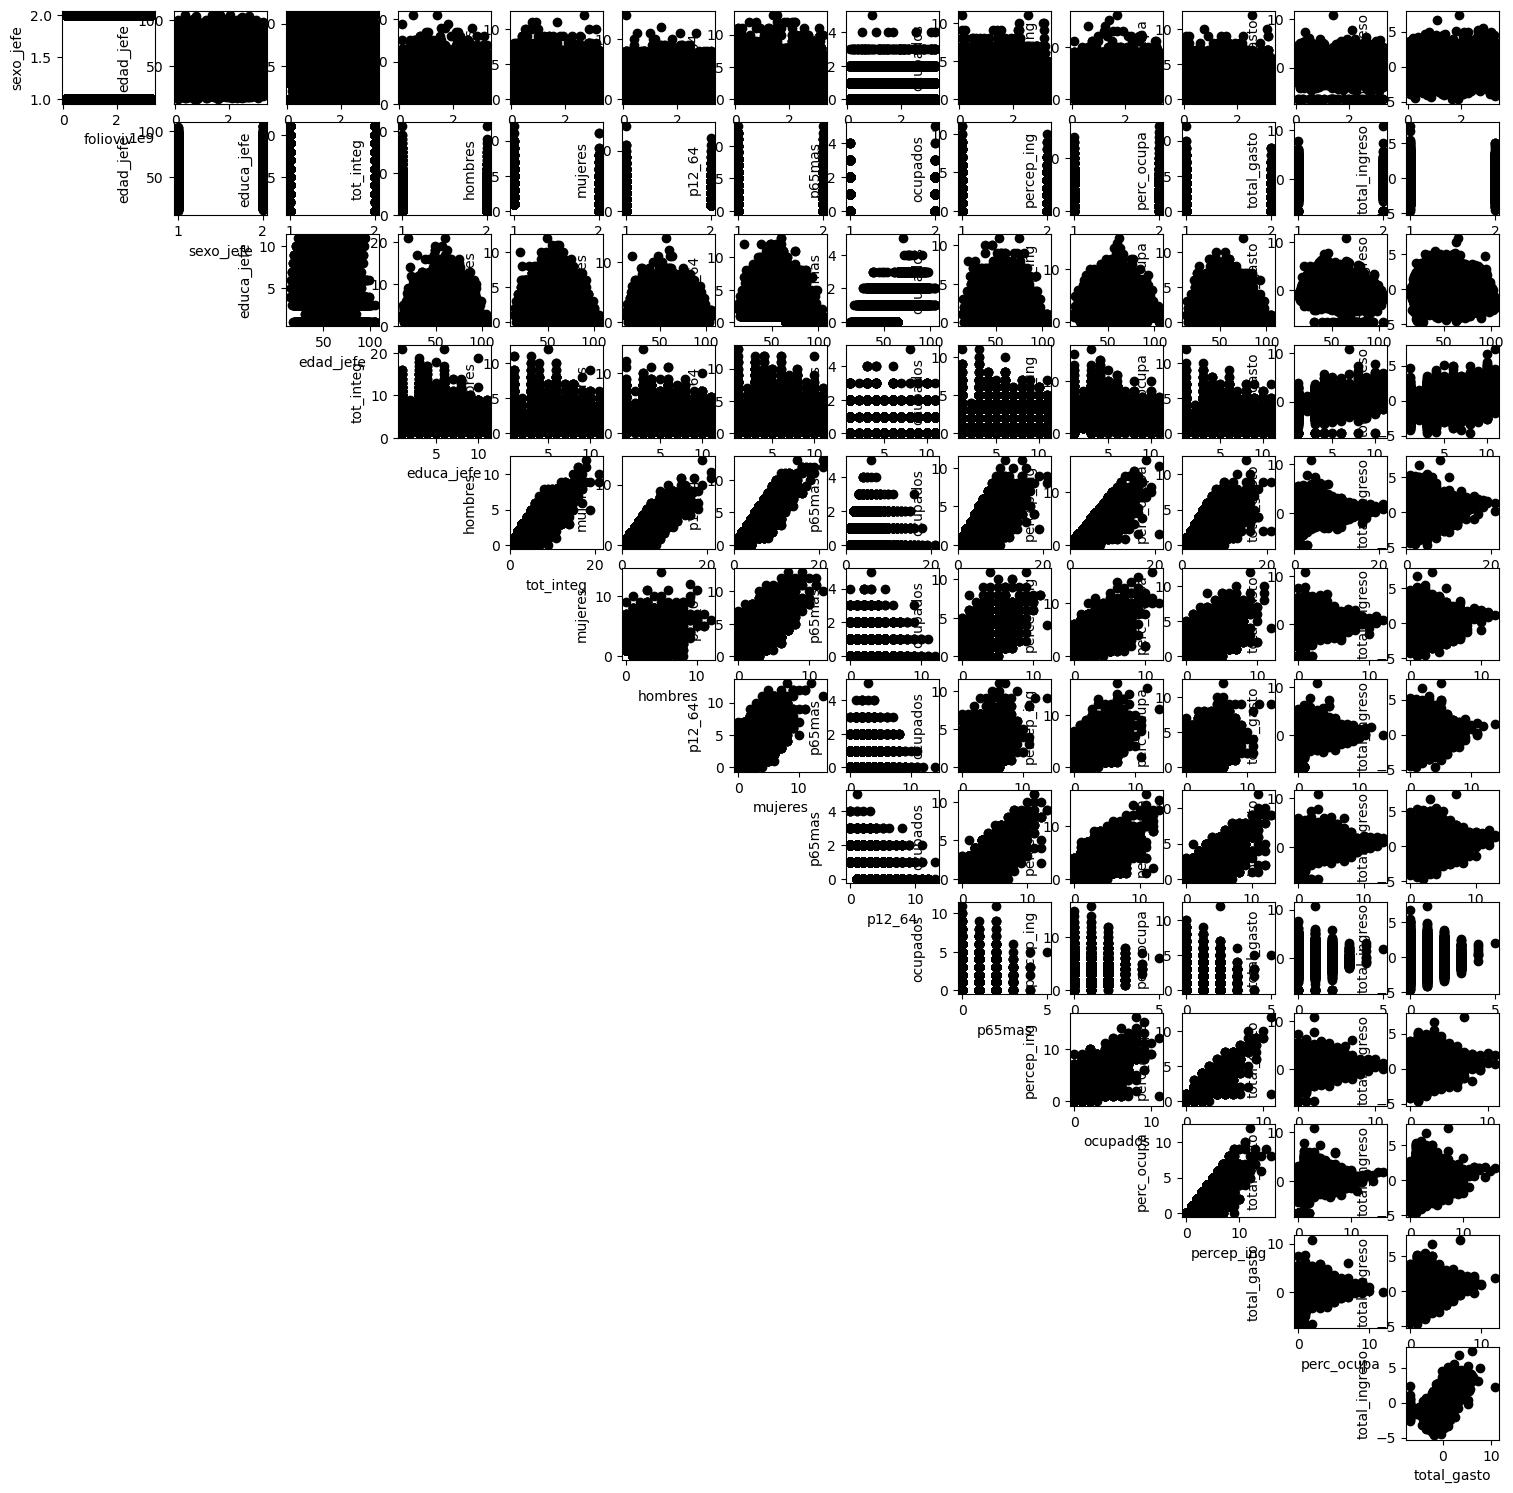

In [34]:
plt.figure(figsize=(20, 20))
for i in range(data.shape[1]):
    for j in range(i + 1, data.shape[1]):
        plt.subplot(data.shape[1], data.shape[1], i * data.shape[1] + j + 1)
        plt.scatter(data.iloc[:, i], data.iloc[:, j])
        plt.xlabel(data.columns[i])
        plt.ylabel(data.columns[j])
plt.show()

**n.** Trabajo con medias

In [36]:
diff_from_mean = data - data.mean()

abs_diff_from_mean = np.abs(diff_from_mean)

potential_outliers = abs_diff_from_mean > 3 * data.std()

outliers = data[potential_outliers.any(axis=1)]

outliers

folioviv  sexo_jefe  edad_jefe  educa_jefe  tot_integ  hombres  \
10      100027701          2         50          10          3        1   
14      100031901          2         41           4          9        4   
32      100068003          1         41           6          7        3   
56      100101404          2         85           3          1        0   
60      100103703          1         76           3          1        1   
...           ...        ...        ...         ...        ...      ...   
70265  3260774318          2         23           6          3        1   
70269  3260774422          1         60           3          3        2   
70292  3260801007          1         65          11          4        2   
70299  3260801215          1         55           6         10        6   
70300  3260801218          2         73           1          1        0   

       mujeres  p12_64  p65mas  ocupados  percep_ing  perc_ocupa  total_gasto  \
10           2       3       0         3           3           3     3.930861   
14           5       6       0         5           5           5     0.045483   
32           4       5       0         5           3           3    -0.203572   
56           1       0       1         0           1           0    -6.581060   
60           0       0       1         1           1           1    -1.765799   
...        ...     ...     ...       ...         ...         ...          ...   
70265        2       1       0         0           1           0    -1.485447   
70269        1       3       0         0           2           0    -2.391583   
70292        2       3       1         4           4           4     4.245051   
70299        4       5       1         4           5           4     0.974295   
70300        1       0       1         0           1           0    -0.769731   

       total_ingreso  
10          3.572102  
14         -0.414638  
32         -0.156635  
56          0.007552  
60         -3.059472  
...              ...  
70265      -3.562782  
70269      -3.085315  
70292       2.129269  
70299       0.641460  
70300      -4.139507  

[3534 rows x 14 columns]

#### **3° Variables mas importantes**

In [37]:
# Determinar si el hogar está en endeudamiento
data['endeudamiento'] = data['total_ingreso'] < data['total_gasto']

# Llevar endeudamiento a 1 y 0
data['endeudamiento'] = data['endeudamiento'].astype(int)

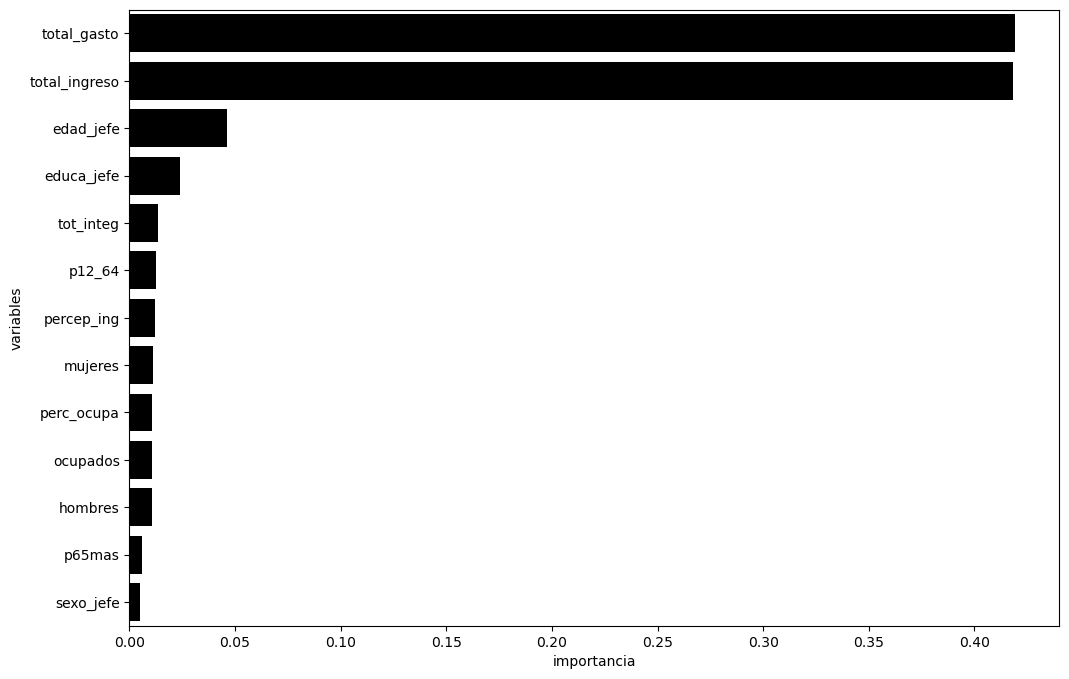

In [38]:
# Crear un objeto de random forest
rf = RandomForestClassifier()

# Separar las variables x y y
X = data.drop(['folioviv', 'endeudamiento'], axis=1)
y = data['endeudamiento']

# Entrenar el modelo
rf.fit(X, y)

# Obtener la importancia de las variables
importancia = rf.feature_importances_

# Crear un dataframe con la importancia de las variables
df_importancia = pd.DataFrame({'variables': X.columns, 'importancia': importancia})
df_importancia = df_importancia.sort_values('importancia', ascending=False)

# Graficar la importancia de las variables
plt.figure(figsize=(12, 8))
sns.barplot(x='importancia', y='variables', data=df_importancia)
plt.show()

In [39]:
# Cantidad de valores unicos en variable "endeudamiento"
data['endeudamiento'].value_counts()

endeudamiento
1    35654
0    34657
Name: count, dtype: int64

#### **4° Comparación de modelos**

**a.** Preparación de los datos

In [40]:
X = X.drop(['total_gasto', 'total_ingreso'], axis=1)

In [41]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**b.** Regresión Logística

Accuracy: 0.5762639550593757
Precision: 0.5765404986435861
Recall: 0.6247200447928332
F1 Score: 0.5996640913671482
              precision    recall  f1-score   support

           0       0.58      0.53      0.55      6919
           1       0.58      0.62      0.60      7144

    accuracy                           0.58     14063
   macro avg       0.58      0.58      0.57     14063
weighted avg       0.58      0.58      0.58     14063



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


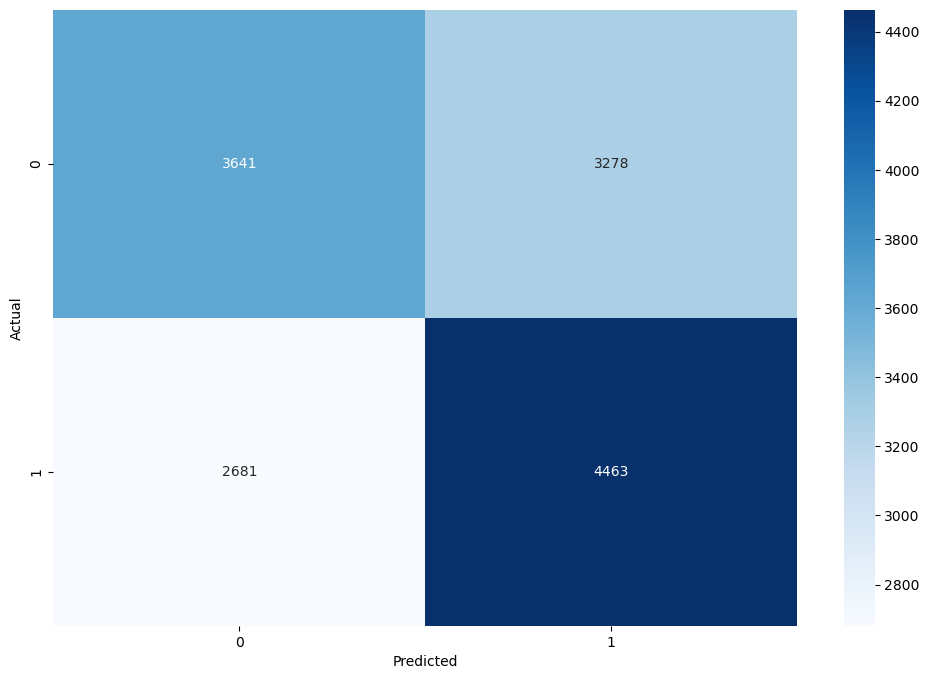

In [42]:
log_reg = LogisticRegression()

log_reg.fit(x_train, y_train)

y_pred = log_reg.predict(x_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**c.** Random Forest

Accuracy: 0.5348076512835099
Precision: 0.541609068288637
Recall: 0.5484322508398656
F1 Score: 0.5449993044929754
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      6919
           1       0.54      0.55      0.54      7144

    accuracy                           0.53     14063
   macro avg       0.53      0.53      0.53     14063
weighted avg       0.53      0.53      0.53     14063



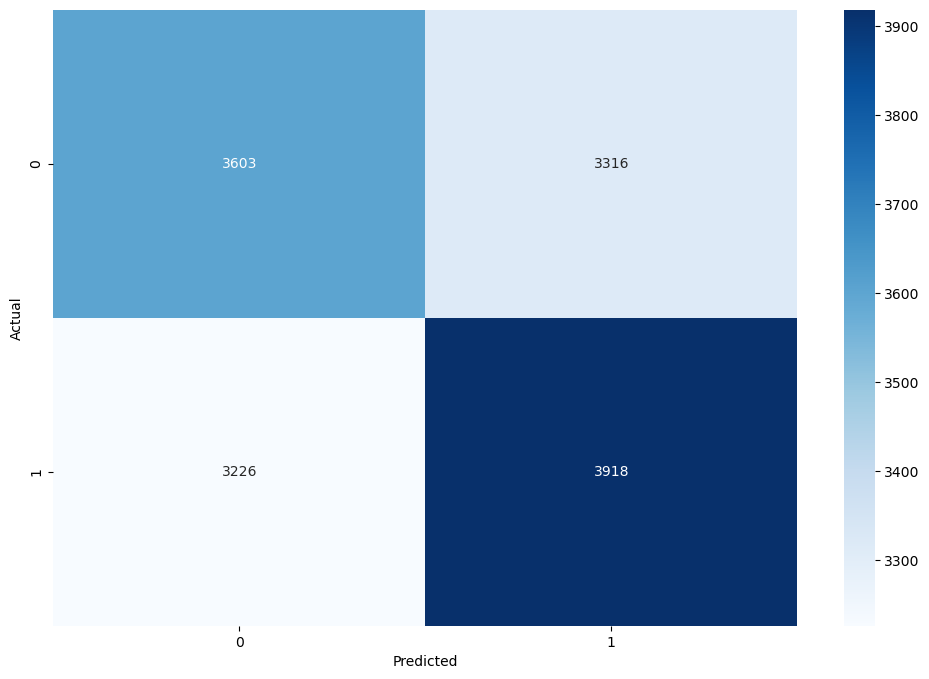

In [43]:
rf = RandomForestClassifier()

rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**d.** KNN

Accuracy: 0.5437673327170589
Precision: 0.5510805500982319
Recall: 0.5496920492721165
F1 Score: 0.550385423966363
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      6919
           1       0.55      0.55      0.55      7144

    accuracy                           0.54     14063
   macro avg       0.54      0.54      0.54     14063
weighted avg       0.54      0.54      0.54     14063



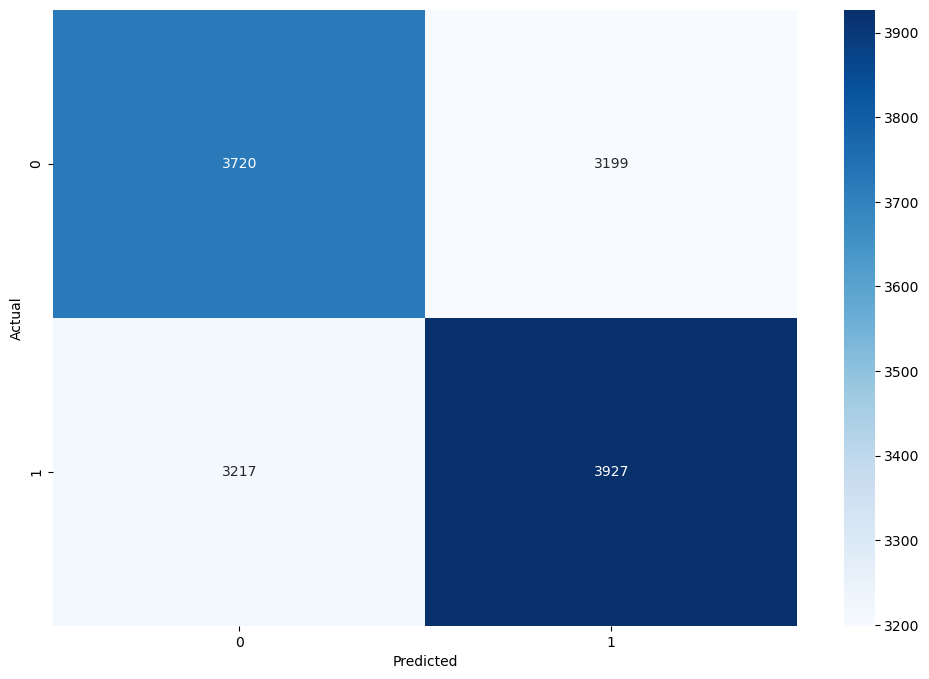

In [44]:
knn = KNeighborsClassifier()

knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Precision: ' + str(precision_score(y_test, y_pred)))
print('Recall: ' + str(recall_score(y_test, y_pred)))
print('F1 Score: ' + str(f1_score(y_test, y_pred)))

print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()